# Import libraries

In [ ]:
! pip install catboost
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict # 교차검증
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
import category_encoders as ce

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('axes, unicode_minus = False')

In [ ]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


# Variable definition

In [ ]:
import easydict
args = easydict.EasyDict

args.default_path ="/content/data/MyDrive/Spaceship_Titanic/"
args.train_csv = args.default_path + 'datas/train.csv'
args.test_csv = args.default_path + 'datas/test.csv'
args.default_submission_csv = args.default_path + 'datas/sample_submission.csv'


args.save_results = args.default_path + 'results/model_results.json'
args.submission_csv = args.default_path +'results/submission09.csv'
args.random_state = 0
args.results = []

In [ ]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

- PassengerId - 각 승객의 고유 ID입니다. 각 ID는 gggg_pp 형식을 취합니다. 여기서 gggg는 승객이 함께 여행하는 그룹을 나타내고 pp는 그룹 내에서 승객의 번호입니다. 한 그룹의 사람들은 종종 가족 구성원이지만 항상은 아닙니다.
- 홈 플래닛 - 승객이 출발한 행성, 일반적으로 영구 거주하는 행성.
CryoSleep - 승객이 항해 중에 일시 중단된 애니메이션으로 전환되도록 선택했는지 여부를 나타냅니다. 냉동 수면 중인 승객들은 객실에 제한되어 있습니다.
- 객실 - 승객이 머물고 있는 객실 번호입니다. deck/num/side 형식을 취합니다. 여기서 side는 좌현의 경우 P 또는 우현의 경우 S입니다. 
- 목적지 - 승객이 출발할 행성.
- 연령 - 탑승자의 연령입니다.
- VIP - 승객이 항해 중에 특별 VIP 서비스에 대한 비용을 지불했는지 여부. 
- 룸 서비스, 푸드 코트, 쇼핑몰, 스파, VR덱 - 승객이 우주선 타이타닉의 다양한 고급 편의 시설에 청구한 금액.
- 이름 - 승객의 이름과 성입니다.
- Transported - 승객이 다른 차원으로 운송되었는지 여부를 나타냅니다. 이것이 예측하려는 대상 열입니다.

# Data information

In [ ]:
ori_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
ori_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [ ]:
ori_train.isna().sum(), ori_train.nunique(), ori_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


(PassengerId       0
 HomePlanet      201
 CryoSleep       217
 Cabin           199
 Destination     182
 Age             179
 VIP             203
 RoomService     181
 FoodCourt       183
 ShoppingMall    208
 Spa             183
 VRDeck          188
 Name            200
 Transported       0
 dtype: int64,
 PassengerId     8693
 HomePlanet         3
 CryoSleep          2
 Cabin           6560
 Destination        3
 Age               80
 VIP                2
 RoomService     1273
 FoodCourt       1507
 ShoppingMall    1115
 Spa             1327
 VRDeck          1306
 Name            8473
 Transported        2
 dtype: int64,
 None)

In [ ]:
ori_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


# Preprocessing

In [ ]:
train = ori_train.copy()
test = ori_test.copy()

In [ ]:
# column 소문자로 변환
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

In [ ]:
train[['cryosleep', 'vip']] = train[['cryosleep', 'vip']].astype(float)
test[['cryosleep', 'vip']] = test[['cryosleep', 'vip']].astype(float)

train.transported = train.transported.map(lambda x: 1 if x == True else 0)
train.transported = train.transported.astype('O')

In [ ]:
train['last_name'] = train.name.str.split().str[1]
test['last_name'] = test.name.str.split().str[1]

In [ ]:
# PassengerId를 group number와 승객 번호로 분리
train['gggg'] = train.passengerid.str[:4]
train['pp'] = train.passengerid.str[-2:].astype('int16')

test['gggg'] = test.passengerid.str[:4]
test['pp'] = test.passengerid.str[-2:].astype('int16')

train.drop(columns = ['passengerid'], inplace = True)
test.drop(columns = ['passengerid'], inplace = True)

In [ ]:
# gggg와 lastname이 같으면 가족으로 생각하고, family group column 생성 
train['gggg_last_name'] = train.last_name + train.gggg
train['family_group'] = train['gggg_last_name'].map(train['gggg_last_name'].value_counts())
train['family_group'] = train['family_group'].map(lambda x: 6 if x >= 6 else x)

test['gggg_last_name'] = test.last_name + test.gggg
test['family_group'] = test['gggg_last_name'].map(test['gggg_last_name'].value_counts())
test['family_group'] = test['family_group'].map(lambda x: 6 if x >= 6 else x)

In [ ]:
# cabin을 deck, num, side로 분리
train[['deck', 'num', 'side']] = train.cabin.str.split('/', expand = True)
test[['deck', 'num', 'side']] = test.cabin.str.split('/', expand = True)

# drop cabin
train.drop(columns = ['cabin'], inplace = True)
test.drop(columns = ['cabin'], inplace = True)

In [ ]:
# roomservice, foodcourt, shoppingmall, spa, vrdeck -> expenditure
train['expenditure'] = train[['roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck']].sum(axis = 1)
test['expenditure'] = test[['roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck']].sum(axis = 1)

In [ ]:
def add_expenditure_group(expenditure):
    result = 0
    if expenditure <= 716:
        result = 1
    elif expenditure <= 1428:
        result = 2
    else:
        result = 3
    return result

In [ ]:
# expenditure 사분위수 범주화화
train['expenditure_group'] = train['expenditure'].map(lambda x : add_expenditure_group(x))
test['expenditure_group'] = test['expenditure'].map(lambda x : add_expenditure_group(x))

In [ ]:
# EDA 시 target에 가장 영향이 커 보이는 cryosleep을 다른 column들과 합침 
train['home_cryosleep'] = train.apply(lambda x: str(x.homeplanet) + str(x.cryosleep), axis = 1)
test['home_cryosleep'] = test.apply(lambda x: str(x.homeplanet) + str(x.cryosleep), axis = 1)

train['deck_cryosleep'] = train.apply(lambda x: str(x.deck) + str(x.cryosleep), axis = 1)
test['deck_cryosleep'] = test.apply(lambda x: str(x.deck) + str(x.cryosleep), axis = 1)

# train['des_cryosleep'] = train.apply(lambda x: str(x.destination) + str(x.cryosleep), axis = 1)
# test['des_cryosleep'] = test.apply(lambda x: str(x.destination) + str(x.cryosleep), axis = 1)

In [ ]:
# 출발지-도착지 column
train['home_destination'] = train.apply(lambda x: str(x.homeplanet) + ' - ' + str(x.destination), axis = 1)
test['home_destination'] = test.apply(lambda x: str(x.homeplanet) + ' - ' + str(x.destination), axis = 1)

In [ ]:
# 방 번호 별 승객 번호의 max로 group column 생성
df_for_group = train[['gggg','pp']].groupby(['gggg']).max()
df_for_group.rename(columns = {'pp' : 'group'}, inplace = True)
train = train.merge(df_for_group, on = 'gggg', how = 'left')
train.drop(columns = ['gggg', 'pp'], inplace = True)

df_for_group = test[['gggg','pp']].groupby(['gggg']).max()
df_for_group.rename(columns = {'pp' : 'group'}, inplace = True)
test = test.merge(df_for_group, on = 'gggg', how = 'left')
test.drop(columns = ['gggg', 'pp'], inplace = True)

In [ ]:
# age 범주화
train['age_cut'] = pd.cut(train.age, bins = [0, 10, 20, 30, 40, 80], labels = ['10-', '10+', '20+', '30+', '40+'])
test['age_cut'] = pd.cut(test.age, bins = [0, 10, 20, 30, 40, 80], labels = ['10-', '10+', '20+', '30+', '40+'])

In [ ]:
train.drop(columns = ['name', 'last_name','gggg_last_name'], inplace = True)
test.drop(columns = ['name', 'last_name','gggg_last_name'], inplace = True) 

# EDA

In [ ]:
train.columns

Index(['homeplanet', 'cryosleep', 'destination', 'age', 'vip', 'roomservice',
       'foodcourt', 'shoppingmall', 'spa', 'vrdeck', 'transported',
       'family_group', 'deck', 'num', 'side', 'expenditure',
       'expenditure_group', 'home_cryosleep', 'deck_cryosleep',
       'home_destination', 'group', 'age_cut'],
      dtype='object')

<Axes: xlabel='homeplanet', ylabel='count'>

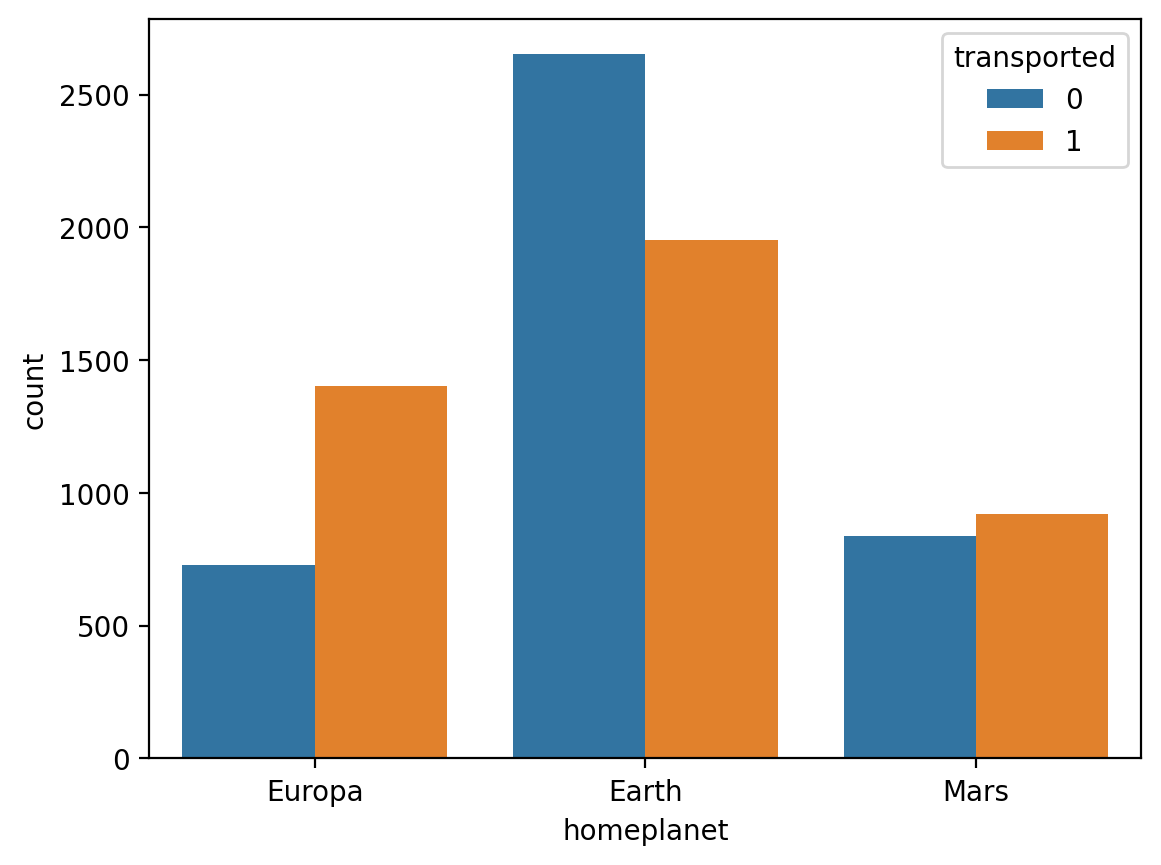

In [ ]:
sns.countplot(data = train, x = 'homeplanet', hue = 'transported')

<Axes: xlabel='destination', ylabel='count'>

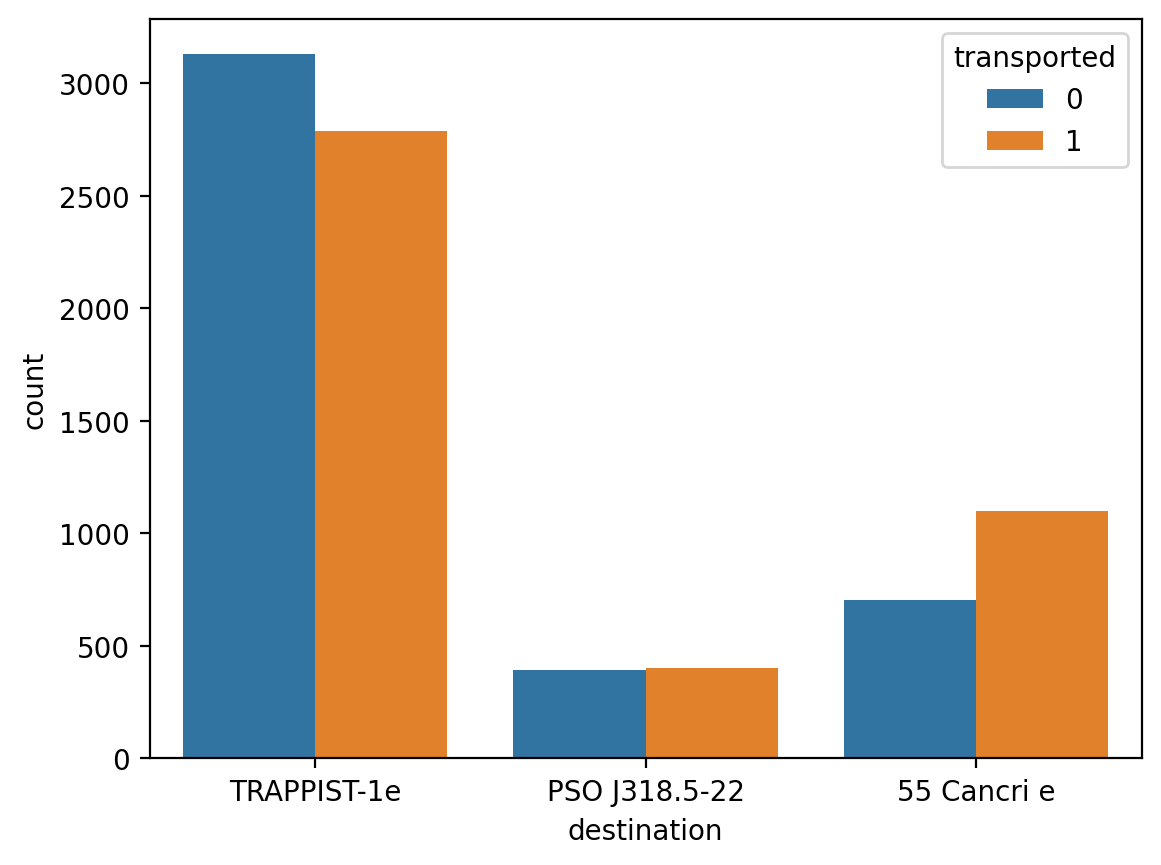

In [ ]:
sns.countplot(data = train, x = 'destination', hue = 'transported')

<Axes: xlabel='cryosleep', ylabel='count'>

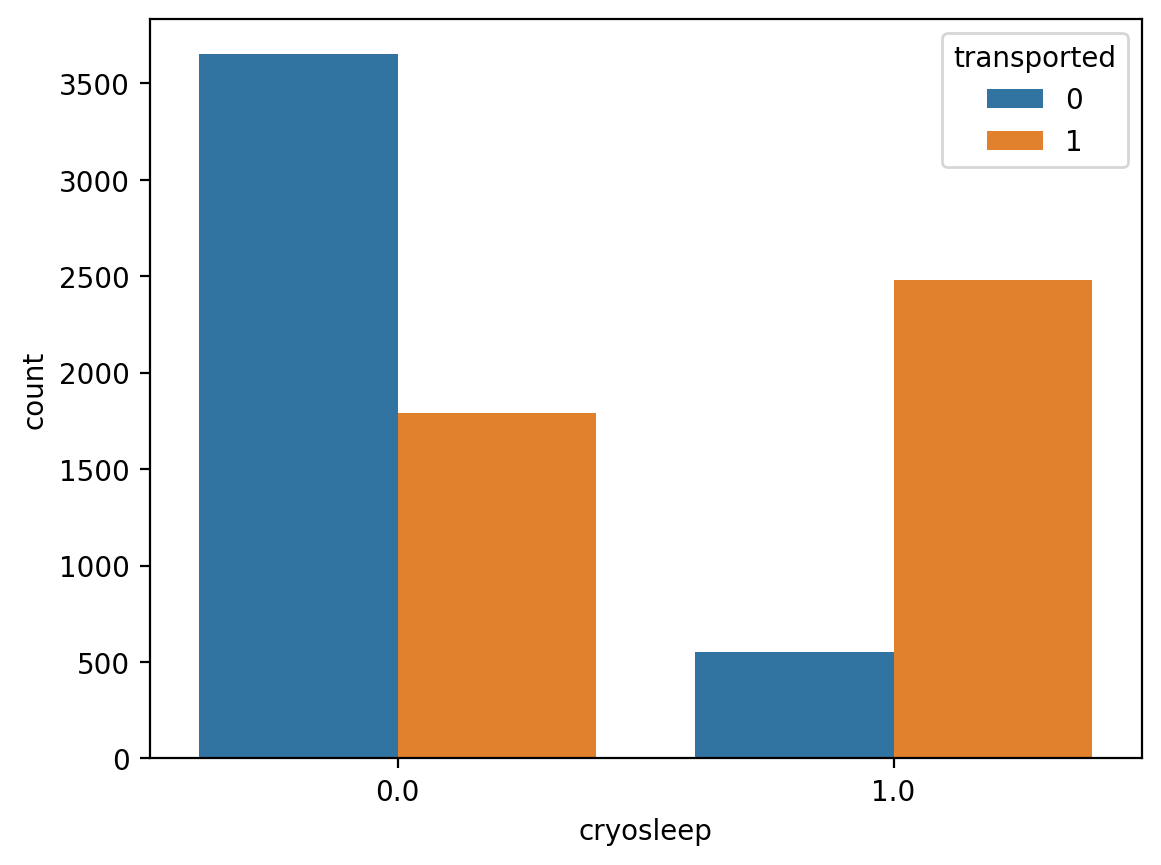

In [ ]:
sns.countplot(data = train, x = 'cryosleep', hue = 'transported')

<Axes: xlabel='vip', ylabel='count'>

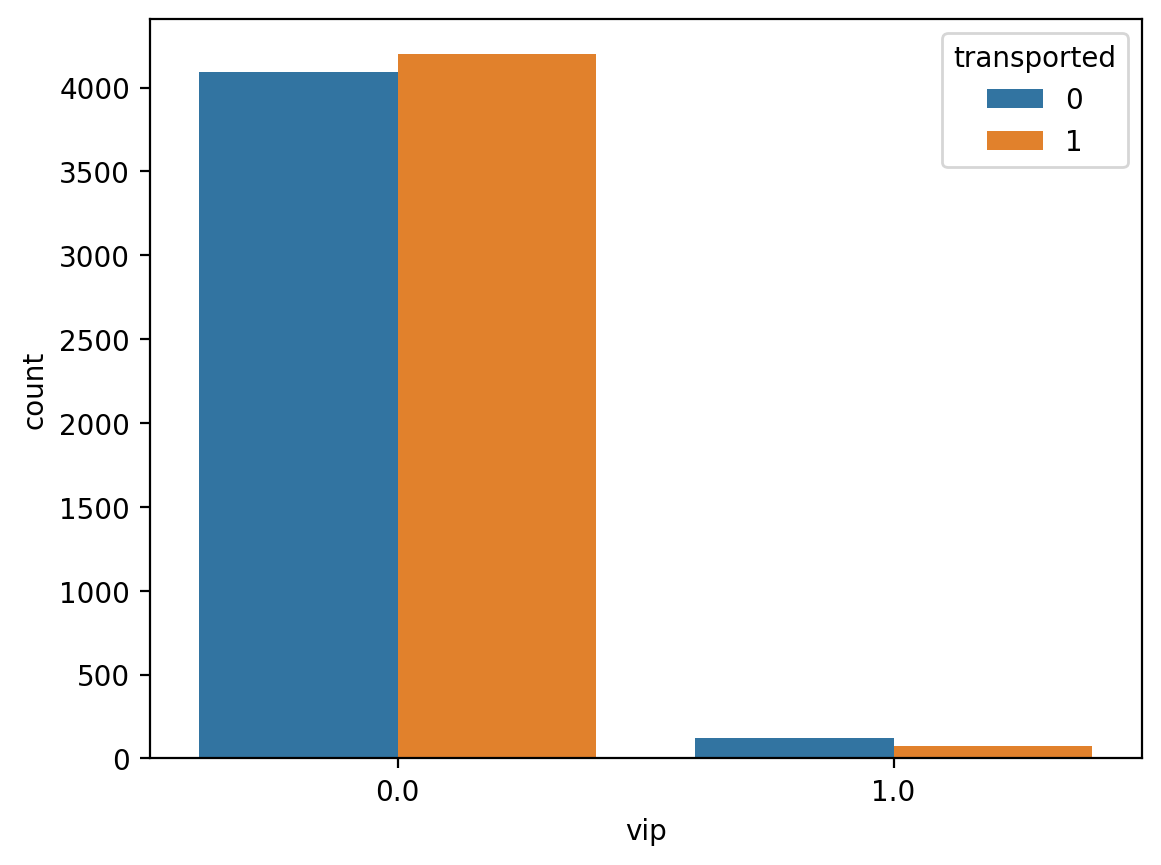

In [ ]:
sns.countplot(data = train, x = 'vip', hue = 'transported')

<Axes: xlabel='age_cut', ylabel='expenditure'>

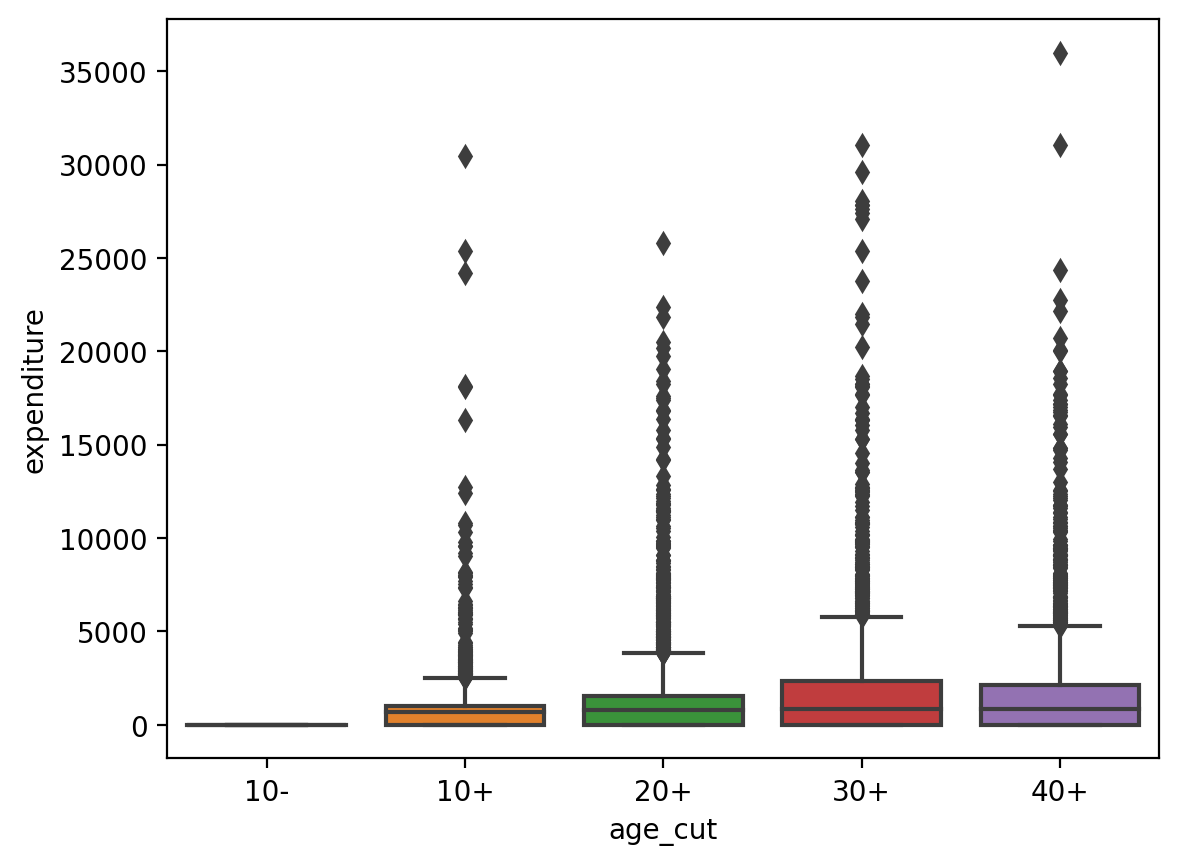

In [ ]:
sns.boxplot(train, x = 'age_cut', y = 'expenditure')

<Axes: xlabel='age', ylabel='Count'>

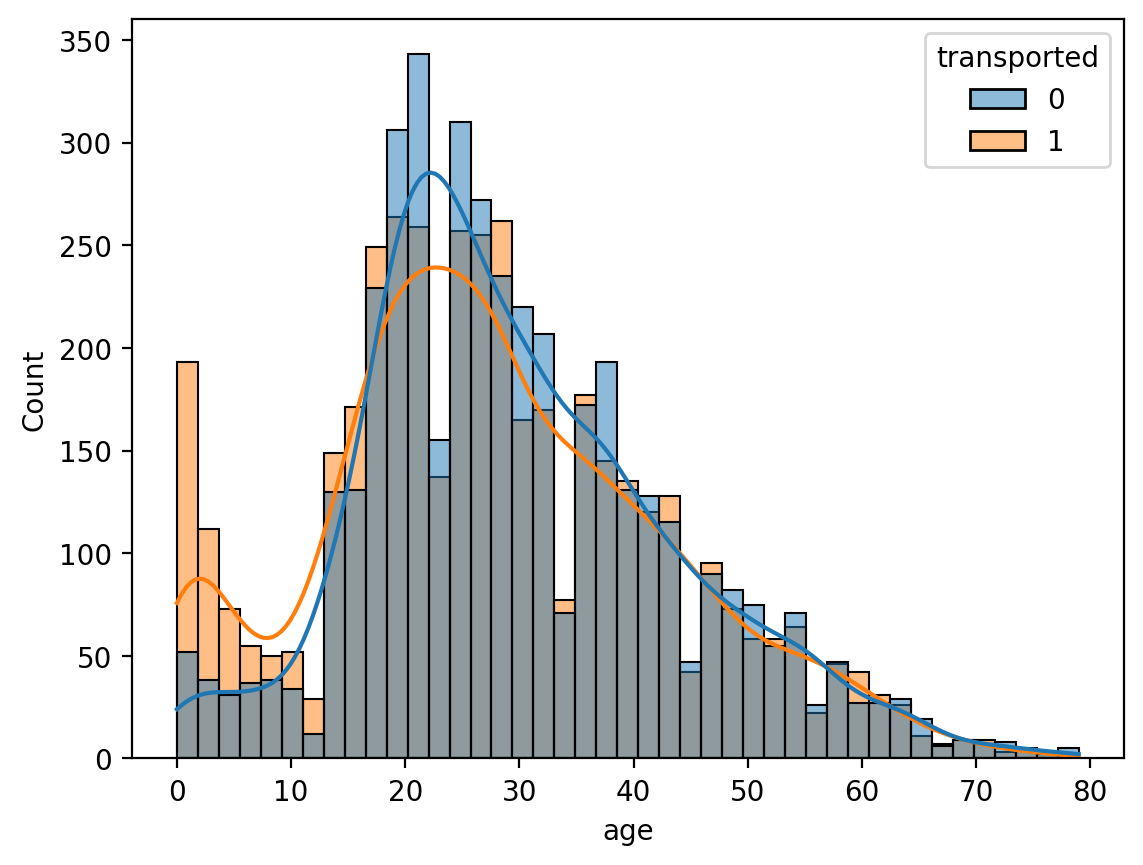

In [ ]:
sns.histplot(data = train, x = 'age', hue = 'transported', kde = True)

In [ ]:
train.columns

Index(['homeplanet', 'cryosleep', 'destination', 'age', 'vip', 'roomservice',
       'foodcourt', 'shoppingmall', 'spa', 'vrdeck', 'transported',
       'family_group', 'deck', 'num', 'side', 'expenditure',
       'expenditure_group', 'home_cryosleep', 'deck_cryosleep',
       'home_destination', 'group', 'age_cut'],
      dtype='object')

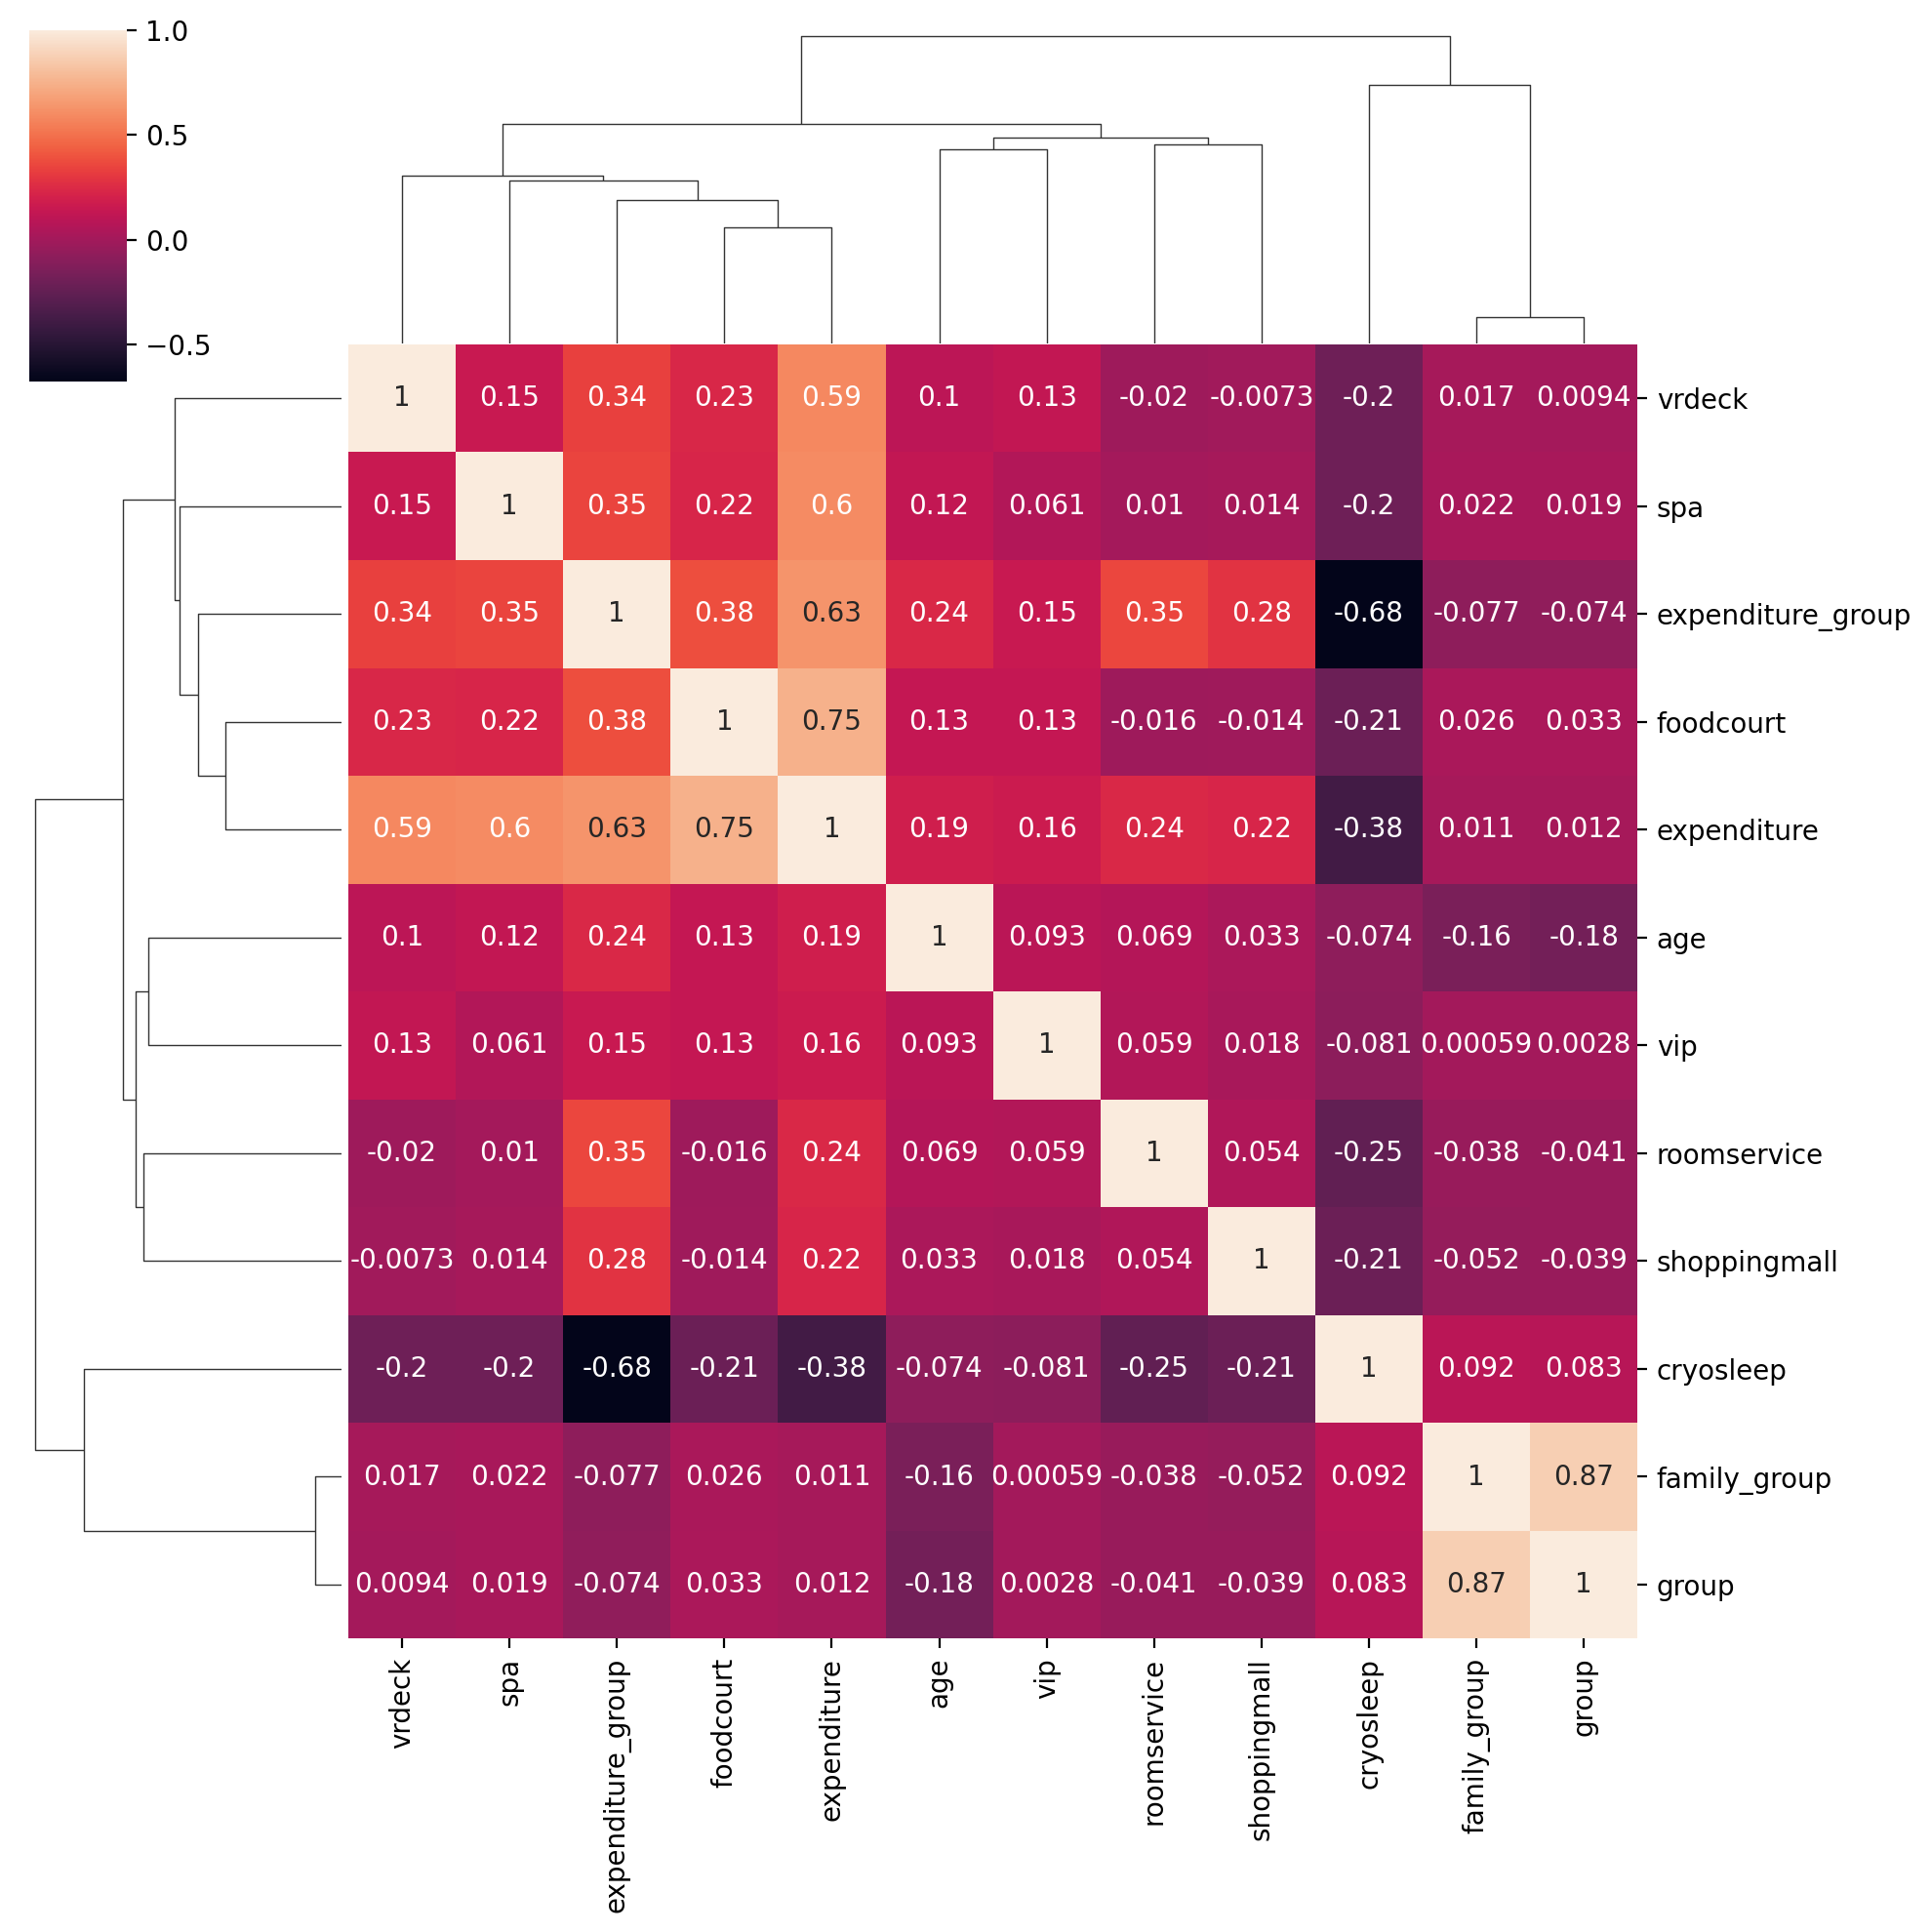

In [ ]:
df = train.corr()
sns.clustermap(df, annot = True)

<Axes: xlabel='Count', ylabel='home_destination'>

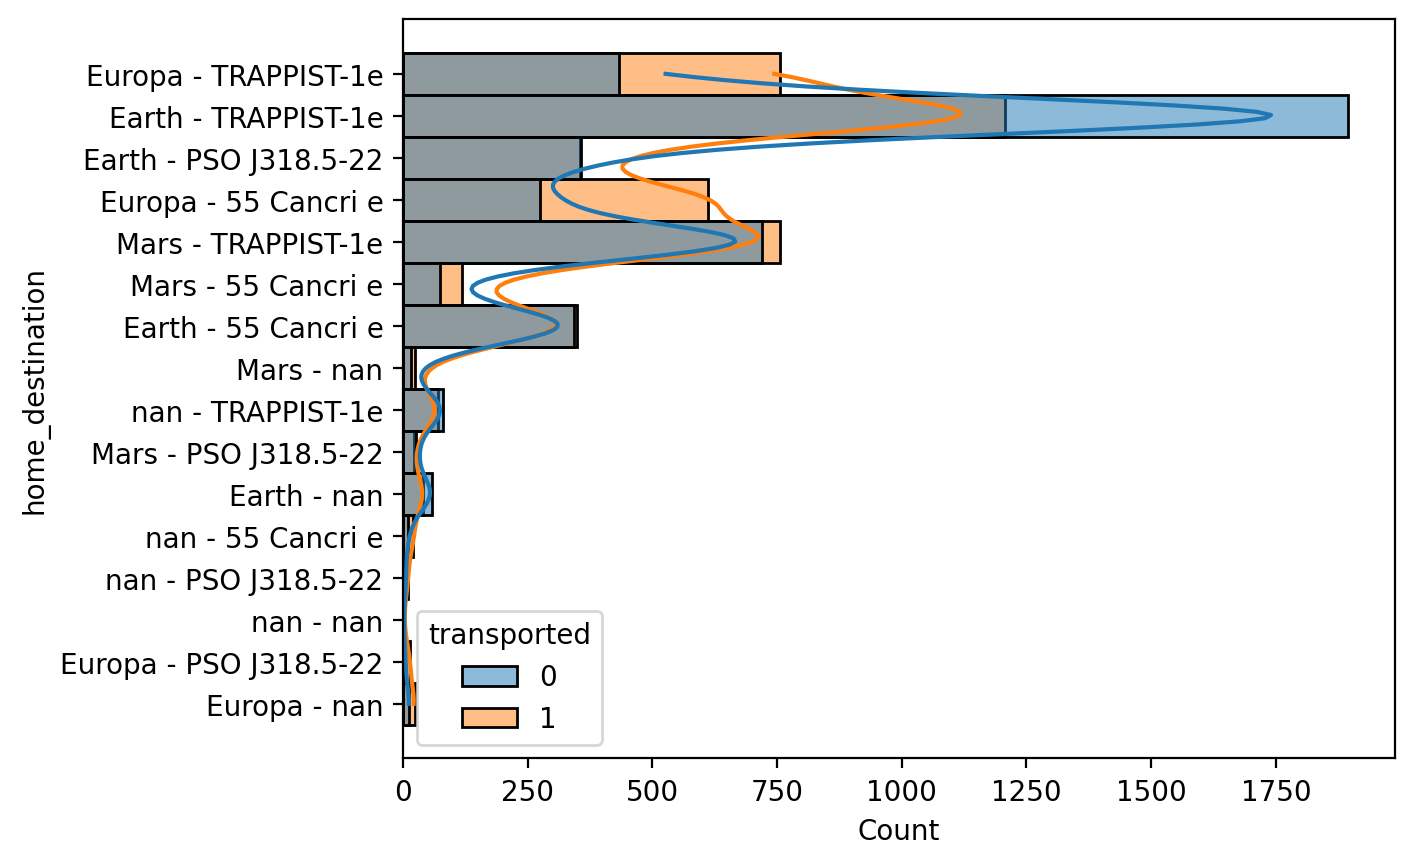

In [ ]:
sns.histplot(train, y = 'home_destination', hue = 'transported', kde = True)

# Missing values

In [ ]:
train.family_group.fillna(train.family_group.mode()[0], inplace = True)
test.family_group.fillna(test.family_group.mode()[0], inplace = True)

In [ ]:
# deck별 나이 평균으로 age 결측치 처리, 나머지는 평균
df_for_age = train[['age', 'deck']].groupby(['deck']).mean().sort_values(by='deck', ascending = False)
df_for_age.rename(columns = {'age' : 'age_mean'}, inplace = True)

train = train.merge(df_for_age, on = 'deck', how = 'left')
train.age.fillna(train.age_mean, inplace = True)
train.age.fillna(train.age.mean(), inplace = True)

test = test.merge(df_for_age, on = 'deck', how = 'left')
test.age.fillna(test.age_mean, inplace = True)
test.age.fillna(train.age.mean(), inplace = True)

In [ ]:
# age 범주화 업데이트
train['age_cut'] = pd.cut(train.age, bins = [-1, 10, 20, 30, 40, 100], labels = ['10-', '10+', '20+', '30+', '40+'])
test['age_cut'] = pd.cut(test.age, bins = [-1, 10, 20, 30, 40, 100], labels = ['10-', '10+', '20+', '30+', '40+'])

In [ ]:
# 승객들의 출발 행성 별 지출 중위수로  homeplanet 결측치 처리(cryosleep 승객은 해당 승객이 가장 많았던 행성으로 채움)
train['new_homeplanet'] = train.apply(lambda x: 'Earth' if x.expenditure < 800 or x.cryosleep == True else 'Mars' if x.expenditure < 1500 else 'Europa', axis = 1)
train.homeplanet.fillna(train.new_homeplanet, inplace = True)

test['new_homeplanet'] = test.apply(lambda x: 'Earth' if x.expenditure < 800 or x.cryosleep == True else 'Mars' if x.expenditure < 1500 else 'Europa', axis = 1)
test.homeplanet.fillna(test.new_homeplanet, inplace = True)

In [ ]:
# 승객 별 도착지 결측치를 도착지 별 지출 평균으로 구분하여 채움(cryosleep이 True인 경우 지출이 0이므로 제외)
train['new_destination'] = train.apply(lambda x: 'TRAPPIST-1e' 
                                       if x.expenditure >700 and x.cryosleep == True 
                                       else '55 Cancri e' if x.expenditure > 500 
                                       else 'PSO J318.5-22', axis = 1)
train.destination.fillna(train.new_destination, inplace = True)

test['new_destination'] = test.apply(lambda x: 'TRAPPIST-1e' 
                                     if x.expenditure >700 and x.cryosleep == True 
                                     else '55 Cancri e' if x.expenditure > 500 
                                     else 'PSO J318.5-22', axis = 1)
test.destination.fillna(test.new_destination, inplace = True)

In [ ]:
# 10세 이상, 지출 0 인 cryosleep 결측치 True로 채움
def add_new_cryosleep(row):
  if not np.isnan(row['cryosleep']):
    return row['cryosleep']
  if (row['age_cut'] != '10-') and (row['expenditure'] == 0):
    return 1.0
  elif (row['age_cut'] != '10-') and (row['expenditure'] != 0):
    return 0.0 

train['new_cryosleep'] = train.apply(lambda x: add_new_cryosleep(x), axis=1)
train.cryosleep.fillna(train.new_cryosleep, inplace = True)

test['new_cryosleep'] = test.apply(lambda x: add_new_cryosleep(x), axis=1)
test.cryosleep.fillna(test.new_cryosleep, inplace = True)

In [ ]:
# 나머지 random으로 채움 
random_sampling = (train['cryosleep'].dropna().sample(train['cryosleep'].isnull().sum()))
random_sampling.index = train[lambda x: x['cryosleep'].isnull()].index # index 부여
train.cryosleep.fillna(random_sampling, inplace = True)

random_sampling = (test['cryosleep'].dropna().sample(test['cryosleep'].isnull().sum()))
random_sampling.index = test[lambda x: x['cryosleep'].isnull()].index # index 부여
test.cryosleep.fillna(random_sampling, inplace = True)

In [ ]:
train.drop(columns = ['age_mean', 'new_homeplanet', 'new_destination', 'new_cryosleep'], inplace = True)
test.drop(columns = ['age_mean', 'new_homeplanet', 'new_destination', 'new_cryosleep'], inplace = True)

In [ ]:
# vip 비율 2%, 결측치 0으로 채움
train.vip.fillna(0, inplace = True)
test.vip.fillna(0, inplace = True)

In [ ]:
train.deck.fillna(train.deck.mode()[0], inplace = True)
train.num.fillna(train.num.mode()[0], inplace = True)
train.side.fillna(train.side.mode()[0], inplace = True)

test.deck.fillna(test.deck.mode()[0], inplace = True)
test.num.fillna(test.num.mode()[0], inplace = True)
test.side.fillna(test.side.mode()[0], inplace = True)

In [ ]:
# 이상치와 0인 row가 많아 결측치 0으로 채움움
train.spa.fillna(0, inplace =True)
train.vrdeck.fillna(0, inplace =True)
train.roomservice.fillna(0, inplace =True)
train.foodcourt.fillna(0, inplace =True)
train.shoppingmall.fillna(0, inplace =True)

test.spa.fillna(0, inplace =True)
test.vrdeck.fillna(0, inplace =True)
test.roomservice.fillna(0, inplace =True)
test.foodcourt.fillna(0, inplace =True)
test.shoppingmall.fillna(0, inplace =True)

In [ ]:
# 출발-도착 컬럼 업데이트
train['home_destination'] = train.apply(lambda x: str(x.homeplanet) + ' - ' + str(x.destination), axis = 1)
test['home_destination'] = test.apply(lambda x: str(x.homeplanet) + ' - ' + str(x.destination), axis = 1)

train['home_cryosleep'] = train.apply(lambda x: str(x.homeplanet) + str(x.cryosleep), axis = 1)
test['home_cryosleep'] = test.apply(lambda x: str(x.homeplanet) + str(x.cryosleep), axis = 1)

train['deck_cryosleep'] = train.apply(lambda x: str(x.deck) + str(x.cryosleep), axis = 1)
test['deck_cryosleep'] = test.apply(lambda x: str(x.deck) + str(x.cryosleep), axis = 1)



In [ ]:
# spa_foodcourt, spa_vrdeck update
train['spa_foodcourt'] = train.apply(lambda x: 1 if x.spa !=0 and x.foodcourt != 0 else 0, axis = 1)
train['spa_vrdeck'] = train.apply(lambda x: 1 if x.spa !=0 and x.vrdeck != 0 else 0, axis = 1)

test['spa_foodcourt'] = test.apply(lambda x: 1 if x.spa !=0 and x.foodcourt != 0 else 0, axis = 1)
test['spa_vrdeck'] = test.apply(lambda x: 1 if x.spa !=0 and x.vrdeck != 0 else 0, axis = 1)

In [ ]:
train.num = train.num.astype('int')
test.num = test.num.astype('int')

In [ ]:
train.isna().sum(), test.isna().sum()

# Encoding

In [ ]:
train.info()

In [ ]:
train.columns

In [ ]:
encoder = ce.OneHotEncoder(use_cat_names=True)

cols_encoding = ['deck_cryosleep','homeplanet','cryosleep','destination','vip','deck','side','home_destination','group','age_cut',
                 'family_group', 'home_cryosleep',  'expenditure_group', 'spa_vrdeck', 'spa_foodcourt']
tmp_tr = train[cols_encoding]
tmp_te = test[cols_encoding]

for col in tmp_tr.columns:
  train_enco = encoder.fit_transform(tmp_tr.astype('category'))
  test_enco = encoder.transform(tmp_te.astype('category'))

print(f'{train_enco.shape} / {test_enco.shape}')
train_enco.head()

(8693, 76) / (4277, 76)


,deck_cryosleep_B0.0,deck_cryosleep_F0.0,deck_cryosleep_A0.0,deck_cryosleep_G1.0,deck_cryosleep_B1.0,deck_cryosleep_G0.0,deck_cryosleep_F1.0,deck_cryosleep_E1.0,deck_cryosleep_E0.0,deck_cryosleep_D0.0,...,home_cryosleep_Europa1.0,home_cryosleep_Mars0.0,home_cryosleep_Mars1.0,expenditure_group_1.0,expenditure_group_2.0,expenditure_group_3.0,spa_vrdeck_0.0,spa_vrdeck_1.0,spa_foodcourt_0.0,spa_foodcourt_1.0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1


In [ ]:
tr = pd.concat([train[['age','expenditure','num', 'roomservice','foodcourt', 'shoppingmall', 'spa', 'vrdeck','transported']],train_enco],axis = 1)
te = pd.concat([test[['age', 'expenditure','num','roomservice','foodcourt', 'shoppingmall', 'spa', 'vrdeck']],test_enco],axis = 1)

# Training

In [ ]:
# model error방지 
tr = tr.apply(pd.to_numeric, errors='coerce')
te = te.apply(pd.to_numeric, errors='coerce')

In [ ]:
X = tr.drop(columns = ['transported'])
y = tr.transported

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.3)
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((6085, 84), (2608, 84), (6085,), (2608,))

In [ ]:
# 각 모델 별 실행 결과 df 반환 함수 
def models_scores_df(X, y, test, SEED):
    results = []
    cat = CatBoostClassifier(verbose = False)
    lgb = LGBMClassifier()
    rf = RandomForestClassifier()
    xgb = XGBClassifier()

    clf_dict = {'CatBoost' : cat,
                  'LGBM' : lgb,
                  'RandomForest': rf,
                  'XGB' : xgb}

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

    for name, clf in clf_dict.items():
        model = clf.fit(X_train, y_train)
        model_name = name
        score_tr = clf.score(X_train,y_train)
        score_te = clf.score(X_test,y_test)
        top_features = pd.Series(model.feature_importances_, index = X_train.columns)


        results.append({
            'model': model_name,
            'score_tr':score_tr,
            'score_te': score_te,
            'feaute_importances': top_features.sort_values(ascending=False)
        })

        df = pd.DataFrame(results).sort_values(by=['score_te'], ascending=False)

    return df

In [ ]:
results = models_scores_df(X, y, te, args.random_state)

In [ ]:
results # CatBoost가 가장 성능이 좋았음 

,model,score_te,feaute_importances
0,CatBoost,0.817868,expenditure 10....
3,XGB,0.813650,homeplanet_Earth 0.181917 cryosleep_0.0 ...
1,LGBM,0.811350,num 496...
2,RandomForest,0.801764,num 0.1...


In [ ]:
# 중요도 낮은 feature 위주로 확인 
results.loc[1].feaute_importances[:50]

num                                      496
age                                      301
spa                                      268
expenditure                              256
vrdeck                                   244
foodcourt                                241
shoppingmall                             211
roomservice                              204
side_P                                    98
homeplanet_Earth                          34
destination_TRAPPIST-1e                   32
deck_cryosleep_G0.0                       31
deck_C                                    26
deck_cryosleep_C0.0                       24
home_cryosleep_Europa1.0                  24
deck_cryosleep_E0.0                       24
deck_cryosleep_E1.0                       23
family_group_1.0                          23
side_S                                    21
deck_cryosleep_F0.0                       19
age_cut_30+                               19
destination_55 Cancri e                   18
home_desti

In [ ]:
## 위에서 확인한 feature를 바꿔가며 점수 확인
# X_tr.drop(columns = ['deck_T', 'home_destination_Europa - PSO J318.5-22', 'expenditure_group_3.0', 'home_destination_Mars - PSO J318.5-22',
#                    'spa_foodcourt_1.0', 'vip_1.0', 'family_group_5.0','home_cryosleep_Earth1.0', 'vip_0.0', 'group_8.0',
#                    'group_5.0','home_destination_Earth - PSO J318.5-22'], inplace = True)
# X_te.drop(columns = ['deck_T', 'home_destination_Europa - PSO J318.5-22', 'expenditure_group_3.0', 'home_destination_Mars - PSO J318.5-22',
#                    'spa_foodcourt_1.0', 'vip_1.0', 'family_group_5.0','home_cryosleep_Earth1.0', 'vip_0.0','group_8.0',
#                    'group_5.0','home_destination_Earth - PSO J318.5-22'], inplace = True)
# te.drop(columns = ['deck_T', 'home_destination_Europa - PSO J318.5-22', 'expenditure_group_3.0', 'home_destination_Mars - PSO J318.5-22',
#                    'spa_foodcourt_1.0', 'vip_1.0', 'family_group_5.0','home_cryosleep_Earth1.0', 'vip_0.0', 'group_8.0',
#                    'group_5.0','home_destination_Earth - PSO J318.5-22'], inplace = True)        

## HPO
- TPE사용

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.9 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from optuna.samplers import TPESampler
optuna.logging.disable_default_handler()

In [ ]:
class Objective:
    def __init__(self,x_train,y_train,seed):
        self.x_train = x_train
        self.y_train = y_train
        self.seed = seed
        num_folds=2 # 학습시간을 줄이기 위해 2로 하였다. 일반적으로는 5
        self.cv = KFold(n_splits=num_folds,shuffle=True,random_state=self.seed)
    def __call__(self,trial):
        hp = {
            "max_depth" : trial.suggest_int("max_depth",1,5),
            "n_estimators" : trial.suggest_int("n_estimators",10,500,50),
            "learning_rate" : trial.suggest_float("learning_rate",0.01,0.1)
        }
        model = CatBoostClassifier(random_state=self.seed,**hp, verbose = False)
        scores = cross_val_score(model,self.x_train,self.y_train, cv = self.cv , scoring="roc_auc")
        return np.mean(scores)

In [ ]:
sampler = TPESampler(seed=args.random_state) # 대체모델 부분

# 스터디 객체
study = optuna.create_study(
    direction = "maximize", # maximize or minimize
    sampler = sampler
)
objective = Objective(X_tr, y_tr, args.random_state)
study.optimize(objective,n_trials=50)

print("Best Score:", study.best_value) # 최고점수
print("Best hp", study.best_params) # 최고점수의 하이퍼파라미터조합

Best Score: 0.8951892749711665
Best hp {'max_depth': 5, 'n_estimators': 260, 'learning_rate': 0.051469486442151685}


In [ ]:
model = CatBoostClassifier(random_state=args.random_state, **study.best_params, verbose = 0)
model.fit(X_tr,y_tr)

pred = model.predict(X_te)
roc_auc_score(y_te,pred)

0.8199393979316252

In [ ]:
pred = model.predict(te)
pred[:20]

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0])

In [ ]:
te.shape

(4277, 84)

In [ ]:
submission = pd.read_csv(args.default_submission_csv)
submission

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


In [ ]:
submission.Transported = pred

In [ ]:
submission.Transported.mean()

0.5279401449614216

In [ ]:
submission.Transported = submission.Transported.map(lambda x: True if x == 1 else False)

In [ ]:
submission.to_csv(args.submission_csv, header = True, index = False)